<center> <h1>MSDS 7331 - Mini-Project</h1> </center>
<center> <h1>Johnson Ekedum, Ekaterina Pirogova, Victor Yim</h1> </center>
<center> <h2>10/8/2017</h2> </center>
<center> <h1>SVM and Logistic Regression Modeling</h1> </center>


## Introduction to Modeling
Our modeling is only ever as good as our dataset.Before diving into a predictive analysis, We need to make sure that the data is clean and in shape.This includes finding and correcting any records that contain erroneous values,  filling in any missing values and dealing with duplicate records, preprocessing, scaling, feature engineering and transformation. The overall goal is to ensure the integrity of the information we are using to build our predictive model. 






In [1]:
#libraries
import sklearn
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics as mt
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pandas.tools.plotting import boxplot
import seaborn as sns; sns.set(style="white", color_codes=True)

%matplotlib inline

### Data preparation for modeling

In [2]:
diab = pd.read_csv('D:\Documents\Study\SMU\Term3\DataMining\Project\Data\diabetic_data.csv')
pd.options.mode.chained_assignment = None #supress warnings
# Replace missing values to NaN
diab = diab.replace(to_replace='?',value=np.nan)
diab["race"] = pd.Categorical(diab.race)
diab["code_race"] = diab.race.cat.codes
diab.ix[diab['code_race']== -1, ["code_race"]]=np.nan

from sklearn.preprocessing import Imputer
import numpy as np
imp=Imputer(missing_values="NaN", strategy="most_frequent")
imp.fit(diab[["code_race"]])
diab["code_race"]=imp.transform(diab[["code_race"]]).ravel()

###Imputation gave 2: therefore, we'll replace with caucasians
diab.ix[diab['race'].isnull(),["race"]]="Caucasian"
diab['gender'] = diab['gender'].replace(to_replace='Unknown/Invalid', value='Female')


#create columns
#weight_status
diab['weight_status']=np.nan #empty column
diab['weight_status'][diab['weight'].isnull()] ="Not measured"
diab['weight_status'][diab['weight'].notnull()] ="Measured"
#readmittance
pd.options.mode.chained_assignment = None #supress warnings
diab['readmitted'][diab['readmitted']==">30"]="NO"
diab['readmitted_Group']=np.nan
diab['readmitted_Group'][diab['readmitted']=="NO"]  = 0
diab['readmitted_Group'][diab['readmitted']=="<30"] = 1
diab["readmitted_Group"]=diab["readmitted_Group"].astype('int64')

diab['metformin-rosiglitazoneBinary']=1
diab['metformin-rosiglitazoneBinary'][diab["metformin-rosiglitazone"]=="No"]=0
diab['metformin-pioglitazoneBinary']=1
diab['metformin-pioglitazoneBinary'][diab["metformin-pioglitazone"]=="No"]=0
diab['glimepiride-pioglitazoneBinary']=1
diab['glimepiride-pioglitazoneBinary'][diab["glimepiride-pioglitazone"]=="No"]=0
diab['glipizide-metforminBinary']=1
diab['glipizide-metforminBinary'][diab["glipizide-metformin"]=="No"]=0
diab['glyburide-metforminBinary']=1
diab['glyburide-metforminBinary'][diab["glyburide-metformin"]=="No"]=0
diab['insulinBinary']=1
diab['insulinBinary'][diab["insulin"]=="No"]=0
diab['tolazamideBinary']=1
diab['tolazamideBinary'][diab["tolazamide"]=="No"]=0
diab['troglitazoneBinary']=1
diab['troglitazoneBinary'][diab["troglitazone"]=="No"]=0
diab['miglitolBinary']=1
diab['miglitolBinary'][diab["miglitol"]=="No"]=0
diab['acarboseBinary']=1
diab['acarboseBinary'][diab["acarbose"]=="No"]=0
diab['rosiglitazoneBinary']=1
diab['rosiglitazoneBinary'][diab["rosiglitazone"]=="No"]=0
diab['pioglitazoneBinary']=1
diab['pioglitazoneBinary'][diab["pioglitazone"]=="No"]=0
diab['metforminBinary']=1
diab['metforminBinary'][diab["metformin"]=="No"]=0
diab['repaglinideBinary']=1
diab['repaglinideBinary'][diab["repaglinide"]=="No"]=0
diab['nateglinideBinary']=1
diab['nateglinideBinary'][diab["nateglinide"]=="No"]=0
diab['chlorpropamideBinary']=1
diab['chlorpropamideBinary'][diab["chlorpropamide"]=="No"]=0
diab['glimepirideBinary']=1
diab['glimepirideBinary'][diab["glimepiride"]=="No"]=0
diab['acetohexamideBinary']=1
diab['acetohexamideBinary'][diab["acetohexamide"]=="No"]=0
diab['glipizideBinary']=1
diab['glipizideBinary'][diab["glipizide"]=="No"]=0
diab['glyburideBinary']=1
diab['glyburideBinary'][diab["glyburide"]=="No"]=0
diab['tolbutamideBinary']=1
diab['tolbutamideBinary'][diab["tolbutamide"]=="No"]=0
#let's check if some person takes multiple diabeties managment medications
medication_col=['metforminBinary','repaglinideBinary','nateglinideBinary','chlorpropamideBinary'
                  ,'glimepirideBinary','acetohexamideBinary','glipizideBinary','glyburideBinary','tolbutamideBinary',
                'pioglitazoneBinary','rosiglitazoneBinary','acarboseBinary','miglitolBinary','troglitazoneBinary',
                'tolazamideBinary','insulinBinary','glyburide-metforminBinary','glipizide-metforminBinary',
                'glimepiride-pioglitazone','metformin-rosiglitazoneBinary','metformin-pioglitazoneBinary',
               "glimepiride-pioglitazoneBinary",'metformin-rosiglitazoneBinary','metformin-pioglitazoneBinary']
diab["diab_medications_count"]=np.nan
diab["diab_medications_count"]=diab[medication_col].sum(axis=1)
diab.drop(medication_col,axis=1, inplace = True)
diag_num=["diag_1","diag_2","diag_3"]
#replace diagnosis containing E and V as -1 and -2
diab[diag_num] = diab[diag_num].replace({'E':'-1'}, regex=True)
diab[diag_num] = diab[diag_num].replace({'V':'-2'}, regex=True)

diab[diag_num] = diab[diag_num].astype(np.float)
#bin by diagnosis type
pd.options.mode.chained_assignment = None #supress warnings
#diagnosis 1
diab['diag_1_cat']=np.nan #empty column
diab['diag_1_cat'][(diab['diag_1']>=-2000)&(diab['diag_1']<1)] ="Other"
diab['diag_1_cat'][(diab['diag_1']>=280)&(diab['diag_1']<=389)] ="Other"
diab['diag_1_cat'][(diab['diag_1']>=630)&(diab['diag_1']<=679)] ="Other"
diab['diag_1_cat'][(diab['diag_1']>=740)&(diab['diag_1']<=759)] ="Other"
diab['diag_1_cat'][(diab['diag_1']>=1)&(diab['diag_1']<250)] ="Neoplasms"
diab['diag_1_cat'][(diab['diag_1']>=251)&(diab['diag_1']<280)] ="Neoplasms"
diab['diag_1_cat'][(diab['diag_1']>=790)&(diab['diag_1']<=799)|((diab['diag_1']==780))|((diab['diag_1']==781))
                  |((diab['diag_1']==784))] ="Neoplasms"
diab['diag_1_cat'][(diab['diag_1']>=680)&(diab['diag_1']<=709)|((diab['diag_1']==782))]="Neoplasms"
diab['diag_1_cat'][(diab['diag_1']>=250)&(diab['diag_1']<251)] ="Diabeties"
diab['diag_1_cat'][(diab['diag_1']>=390)&(diab['diag_1']<=459)|((diab['diag_1']==785))] ="Circulatory"
diab['diag_1_cat'][(diab['diag_1']>=460)&(diab['diag_1']<=519)|((diab['diag_1']==786))] ="Respiratory"
diab['diag_1_cat'][(diab['diag_1']>=520)&(diab['diag_1']<=579)|((diab['diag_1']==787))] ="Digestive"
diab['diag_1_cat'][(diab['diag_1']>=800)&(diab['diag_1']<=999)] ="Injury"
diab['diag_1_cat'][(diab['diag_1']>=710)&(diab['diag_1']<=739)] ="Musculoskeletal"
diab['diag_1_cat'][(diab['diag_1']>=580)&(diab['diag_1']<=629)|((diab['diag_1']==788))] ="Genitourinary"
diab['diag_1_cat'][diab['diag_1'].isnull()] ="No diagnosis"
#diagnosis 2
diab['diag_2_cat']=np.nan #empty column
diab['diag_2_cat'][(diab['diag_2']>=-2000)&(diab['diag_2']<1)] ="Other"
diab['diag_2_cat'][(diab['diag_2']>=280)&(diab['diag_2']<=389)] ="Other"
diab['diag_2_cat'][(diab['diag_2']>=630)&(diab['diag_2']<=679)] ="Other"
diab['diag_2_cat'][(diab['diag_2']>=740)&(diab['diag_2']<=759)] ="Other"
diab['diag_2_cat'][(diab['diag_2']>=1)&(diab['diag_2']<250)] ="Neoplasms"
diab['diag_2_cat'][(diab['diag_2']>=251)&(diab['diag_2']<280)] ="Neoplasms"
diab['diag_2_cat'][(diab['diag_2']>=790)&(diab['diag_2']<=799)|((diab['diag_2']==780))|((diab['diag_2']==781))
                  |((diab['diag_2']==784))] ="Neoplasms"
diab['diag_2_cat'][(diab['diag_2']>=680)&(diab['diag_2']<=709)|((diab['diag_2']==782))]="Neoplasms"
diab['diag_2_cat'][(diab['diag_2']>=250)&(diab['diag_2']<251)] ="Diabeties"
diab['diag_2_cat'][(diab['diag_2']>=390)&(diab['diag_2']<=459)|((diab['diag_2']==785))] ="Circulatory"
diab['diag_2_cat'][(diab['diag_2']>=460)&(diab['diag_2']<=519)|((diab['diag_2']==786))] ="Respiratory"
diab['diag_2_cat'][(diab['diag_2']>=520)&(diab['diag_2']<=579)|((diab['diag_2']==787))] ="Digestive"
diab['diag_2_cat'][(diab['diag_2']>=800)&(diab['diag_2']<=999)] ="Injury"
diab['diag_2_cat'][(diab['diag_2']>=710)&(diab['diag_2']<=739)] ="Musculoskeletal"
diab['diag_2_cat'][(diab['diag_2']>=580)&(diab['diag_2']<=629)|((diab['diag_2']==788))] ="Genitourinary"
diab['diag_2_cat'][diab['diag_2'].isnull()] ="No diagnosis"
#diagnosis 3
diab['diag_3_cat']=np.nan #empty column
diab['diag_3_cat'][(diab['diag_3']>=-2000)&(diab['diag_3']<1)] ="Other"
diab['diag_3_cat'][(diab['diag_3']>=280)&(diab['diag_3']<=389)] ="Other"
diab['diag_3_cat'][(diab['diag_3']>=630)&(diab['diag_3']<=679)] ="Other"
diab['diag_3_cat'][(diab['diag_3']>=740)&(diab['diag_3']<=759)] ="Other"
diab['diag_3_cat'][(diab['diag_3']>=1)&(diab['diag_3']<250)] ="Neoplasms"
diab['diag_3_cat'][(diab['diag_3']>=251)&(diab['diag_3']<280)] ="Neoplasms"
diab['diag_3_cat'][(diab['diag_3']>=790)&(diab['diag_3']<=799)|((diab['diag_3']==780))|((diab['diag_3']==781))
                  |((diab['diag_3']==784))] ="Neoplasms"
diab['diag_3_cat'][(diab['diag_3']>=680)&(diab['diag_3']<=709)|((diab['diag_3']==782))]="Neoplasms"
diab['diag_3_cat'][(diab['diag_3']>=250)&(diab['diag_3']<251)] ="Diabeties"
diab['diag_3_cat'][(diab['diag_3']>=390)&(diab['diag_3']<=459)|((diab['diag_3']==785))] ="Circulatory"
diab['diag_3_cat'][(diab['diag_3']>=460)&(diab['diag_3']<=519)|((diab['diag_3']==786))] ="Respiratory"
diab['diag_3_cat'][(diab['diag_3']>=520)&(diab['diag_3']<=579)|((diab['diag_3']==787))] ="Digestive"
diab['diag_3_cat'][(diab['diag_3']>=800)&(diab['diag_3']<=999)] ="Injury"
diab['diag_3_cat'][(diab['diag_3']>=710)&(diab['diag_3']<=739)] ="Musculoskeletal"
diab['diag_3_cat'][(diab['diag_3']>=580)&(diab['diag_3']<=629)|((diab['diag_3']==788))] ="Genitourinary"
diab['diag_3_cat'][diab['diag_3'].isnull()] ="No diagnosis"
#droping original variables
to_drop=['diag_1','diag_2','diag_3']
diab.drop(to_drop,axis=1, inplace = True)

diab["med_cat"]="Other"
diab["med_cat"][(diab["insulin"]=="Up")|(diab["insulin"]=="Down")|(diab["insulin"]=="Steady")]="Insulin"


diab['encounter_id'] = diab['encounter_id'].astype(object)
diab['patient_nbr'] = diab['patient_nbr'].astype(object)
diab['admission_type_id'] = diab['admission_type_id'].astype(object)
diab['discharge_disposition_id'] = diab['discharge_disposition_id'].astype(object)
diab['admission_source_id'] = diab['admission_source_id'].astype(object)
diab['race'] = diab['race'].astype(object)
diab["A1Cresult"] = diab["A1Cresult"].astype(object)
diab["age"] = diab["age"].astype(object)
diab['max_glu_serum'] = diab['max_glu_serum'].astype(object)
diab['gender'] = diab['gender'].astype(object)
diab['diabetesMed'] = diab['diabetesMed'].astype(object)
diab['change'] = diab['change'].astype(object)
# insert dictionary
admission_type_id_dict = {"1" : "Emergency",
"2" : "Urgent",
"3" : "Elective",
"4" : "Newborn",
"5" : "Not Available",
"6" : "NULL",
"7" : "Trauma Center",
"8" : "Not Mapped"}


discharge_disposition_id_dict= {"1" : "Discharged to home",
"2" : "Discharged/transferred to another short term hospital",
"3" : "Discharged/transferred to SNF",
"4" : "Discharged/transferred to ICF",
"5" : "Discharged/transferred to another type of inpatient care institution",
"6" : "Discharged/transferred to home with home health service",
"7" : "Left AMA",
"8" : "Discharged/transferred to home under care of Home IV provider",
"9" : "Admitted as an inpatient to this hospital",
"10" : "Neonate discharged to another hospital for neonatal aftercare",
"11" : "Expired",
"12" : "Still patient or expected to return for outpatient services",
"13" : "Hospice / home",
"14" : "Hospice / medical facility",
"15" : "Discharged/transferred within this institution to Medicare approved swing bed",
"16" : "Discharged/transferred/referred another institution for outpatient services",
"17" : "Discharged/transferred/referred to this institution for outpatient services",
"18" : "NULL",
"19" : "Expired at home. Medicaid only, hospice.",
"20" : "Expired in a medical facility. Medicaid only, hospice.",
"21" : "Expired, place unknown. Medicaid only, hospice.",
"22" : "Discharged/transferred to another rehab fac including rehab units of a hospital .",
"23" : "Discharged/transferred to a long term care hospital.",
"24" : "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.",
"25" : "Not Mapped",
"26" : "Unknown/Invalid",
"30" : "Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere",
"27" : "Discharged/transferred to a federal health care facility.",
"28" : "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital",
"29" : "Discharged/transferred to a Critical Access Hospital (CAH)."}


discharge_disposition_id_dict= {"1" : " Physician Referral",
"2" : "Clinic Referral",
"3" : "HMO Referral",
"4" : "Transfer from a hospital",
"5" : " Transfer from a Skilled Nursing Facility (SNF)",
"6" : " Transfer from another health care facility",
"7" : " Emergency Room",
"8" : " Court/Law Enforcement",
"9" : " Not Available",
"10" : " Transfer from critial access hospital",
"11" : "Normal Delivery",
"12" : " Premature Delivery",
"13" : " Sick Baby",
"14" : " Extramural Birth",
"15" : "Not Available",
"17" : "NULL",
"18" : " Transfer From Another Home Health Agency",
"19" : "Readmission to Same Home Health Agency",
"20" : " Not Mapped",
"21" : "Unknown/Invalid",
"22" : " Transfer from hospital inpt/same fac reslt in a sep claim",
"23" : " Born inside this hospital",
"24" : " Born outside this hospital",
"25" : " Transfer from Ambulatory Surgery Center",
"26" : "Transfer from Hospice"}

diab['med_increase']=0
#then make readmittance binary variable
diab['med_increase'][(diab['metformin']=="Up")|(diab['repaglinide']=="Up")|(diab['nateglinide']=="Up")
                    |(diab['metformin-rosiglitazone']=="Up")|(diab['metformin-pioglitazone']=="Up")
                     |(diab['chlorpropamide']=="Up")|(diab['glimepiride']=="Up")
                     |(diab['acetohexamide']=="Up")|(diab['glipizide']=="Up")|(diab['glyburide']=="Up")
                     |(diab['tolbutamide']=="Up")|(diab['pioglitazone']=="Up")|(diab['rosiglitazone']=="Up")
                     |(diab['acarbose']=="Up")|(diab['miglitol']=="Up")|(diab['troglitazone']=="Up")|(diab['tolazamide']=="Up")
                    |(diab['insulin']=="Up")|(diab['glyburide-metformin']=="Up")|(diab['glipizide-metformin']=="Up")] =1
#drop columns
diab.drop(["payer_code"],axis=1, inplace = True)
diab.drop(["medical_specialty"],axis=1, inplace = True)
diab.drop(["examide"],axis=1, inplace = True)
diab.drop(["citoglipton"],axis=1, inplace = True)
diab.drop(['weight'],axis=1, inplace = True)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### Scaling and normalization
Standardizing scaling of the features so that they are centered around 0 with a standard deviation of 1 is not only important if we are comparing measurements that have different units, but it is also a general requirement for our model to perform well. Here we applied a some number of transformation techniques such as scaling, box-cox transformation to find the best transformation to make our data look more Gaussian, reduce skewnesss, enhance equal spread. 


In [3]:
from scipy.stats import boxcox
from sklearn import preprocessing
#transform and normolize some variables
#num_vedications
diab["num_medications"][diab["num_medications"]==0]=0.0001 #add small value to 0
diab["TrNum_medications"]=np.nan #new variable log transformed num_medications
diab["TrNum_medications"]=np.log(diab["num_medications"])
#diab.drop(['num_medications'],axis=1, inplace = True)
#diab_medications_count
diab["diab_medications_count"][diab["diab_medications_count"]==0]=0.0001 #add small value to 0
diab["TrDiab_medications_count"]=np.nan #new variable log transformed num_medications
diab["TrDiab_medications_count"]=np.sqrt(diab["diab_medications_count"])
diab["TrDiab_medications_count"]=preprocessing.scale(diab["TrDiab_medications_count"])
diab.drop(['diab_medications_count'],axis=1, inplace = True)
#num_procedures
diab["num_procedures"][diab["num_procedures"]==0]=0.0001 #add small value to 0
diab["TrNum_procedures"]=np.nan #new variable log transformed num_medications
diab["TrNum_procedures"]=np.sqrt(diab["num_procedures"])
diab["TrNum_procedures"]=preprocessing.scale(diab["TrNum_procedures"])
diab.drop(['num_procedures'],axis=1, inplace = True)
#Number_emergency
diab["TrNumber_emergency"]=np.nan
diab["number_emergency"][diab["number_emergency"]==0]=0.0001
diab["TrNumber_emergency"],_=boxcox(diab["number_emergency"]) #boxcox for transformation and then normalization
diab["TrNumber_emergency"]=preprocessing.scale(diab["TrNumber_emergency"])
diab.drop(['number_emergency'],axis=1, inplace = True)
#number_inpatient
diab["TrNumber_inpatient"]=np.nan
diab["number_inpatient"][diab["number_inpatient"]==0]=0.0001
diab["TrNumber_inpatient"]=np.log10(diab["number_inpatient"])
diab["TrNumber_inpatient"]=preprocessing.scale(diab["TrNumber_inpatient"])
diab.drop(['number_inpatient'],axis=1, inplace = True)
#number_outpatient
diab["TrNumber_outpatient"]=np.nan
diab["number_outpatient"][diab["number_outpatient"]==0]=0.0001
diab["TrNumber_outpatient"]=np.log10(diab["number_outpatient"])
diab["TrNumber_outpatient"]=preprocessing.scale(diab["TrNumber_outpatient"])
diab.drop(['number_outpatient'],axis=1, inplace = True)
#time_in_hospital
diab["TrTime_in_hospital"]=np.nan
diab["time_in_hospital"][diab["time_in_hospital"]==0]=0.0001
diab["TrTime_in_hospital"],_=boxcox(diab["time_in_hospital"])
diab["TrTime_in_hospital"]=preprocessing.scale(diab["TrTime_in_hospital"])
diab.drop(['time_in_hospital'],axis=1, inplace = True)
#number_diagnoses
diab["TrNumber_diagnoses"]=np.nan
diab["number_diagnoses"][diab["number_diagnoses"]==0]=0.0001
diab["TrNumber_diagnoses"],_=boxcox(diab["number_diagnoses"])
diab["TrNumber_diagnoses"]=np.sqrt(diab["TrNumber_diagnoses"])
diab["TrNumber_diagnoses"]=preprocessing.scale(diab["TrNumber_diagnoses"])
diab.drop(['number_diagnoses'],axis=1, inplace = True)
#num_lab_procedures
diab["TrNum_lab_procedures"]=np.nan
diab["TrNum_lab_procedures"]=preprocessing.scale(diab["num_lab_procedures"])
diab.drop(['num_lab_procedures'],axis=1, inplace = True)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Here we are creating a dummy variables or indicator variables represent an attributes in our dataset with two or more distinct categories/levels.


In [4]:
dummiesList=["med_cat","diag_1_cat","diag_2_cat","diag_3_cat","weight_status","age","gender","race","A1Cresult"]
diab_wDummies = pd.get_dummies(diab[dummiesList])
listToCopy=["TrNum_lab_procedures", "TrNumber_outpatient","TrNumber_emergency", "TrNumber_inpatient", "TrDiab_medications_count",
           "readmitted_Group"]
diab_wDummies= pd.concat((diab_wDummies, diab[listToCopy]), axis=1)
#save for rf model
diab_rf=diab_wDummies

Check if we got the right result:

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
diab_wDummies.describe()

,med_cat_Insulin,med_cat_Other,diag_1_cat_Circulatory,diag_1_cat_Diabeties,diag_1_cat_Digestive,diag_1_cat_Genitourinary,diag_1_cat_Injury,diag_1_cat_Musculoskeletal,diag_1_cat_Neoplasms,diag_1_cat_No diagnosis,diag_1_cat_Other,diag_1_cat_Respiratory,diag_2_cat_Circulatory,diag_2_cat_Diabeties,diag_2_cat_Digestive,diag_2_cat_Genitourinary,diag_2_cat_Injury,diag_2_cat_Musculoskeletal,diag_2_cat_Neoplasms,diag_2_cat_No diagnosis,diag_2_cat_Other,diag_2_cat_Respiratory,diag_3_cat_Circulatory,diag_3_cat_Diabeties,diag_3_cat_Digestive,diag_3_cat_Genitourinary,diag_3_cat_Injury,diag_3_cat_Musculoskeletal,diag_3_cat_Neoplasms,diag_3_cat_No diagnosis,diag_3_cat_Other,diag_3_cat_Respiratory,weight_status_Measured,weight_status_Not measured,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),gender_Female,gender_Male,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,TrNum_lab_procedures,TrNumber_outpatient,TrNumber_emergency,TrNumber_inpatient,TrDiab_medications_count,readmitted_Group
count,101766.000000,101766.000000,101766.000000,101766.00000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,101766.000000
mean,0.534393,0.465607,0.299088,0.08605,0.093106,0.050282,0.068530,0.048710,0.138121,0.000206,0.068382,0.141727,0.313278,0.125720,0.040976,0.082306,0.023859,0.017334,0.184787,0.003518,0.097557,0.107059,0.297801,0.168593,0.038618,0.065641,0.019122,0.018818,0.175393,0.013983,0.126319,0.072303,0.031415,0.968585,0.001582,0.006790,0.016282,0.037095,0.095169,0.169565,0.220928,0.256156,0.168986,0.027445,0.537616,0.462384,0.188766,0.006299,0.770120,0.020017,0.014799,0.037458,0.080734,0.832773,0.049034,3.243938e-16,1.865722e-13,-1.340213e-13,-5.693088e-15,3.281181e-14,0.111599
std,0.498818,0.498818,0.457861,0.28044,0.290582,0.218527,0.252654,0.215262,0.345028,0.014364,0.252402,0.348772,0.463828,0.331535,0.198236,0.274832,0.152609,0.130513,0.388126,0.059208,0.296716,0.309190,0.457294,0.374394,0.192684,0.247654,0.136956,0.135881,0.380304,0.117421,0.332210,0.258990,0.174438,0.174438,0.039744,0.082122,0.126560,0.188995,0.293450,0.375252,0.414874,0.436511,0.374741,0.163378,0.498586,0.498586,0.391325,0.079115,0.420758,0.140057,0.120747,0.189883,0.272428,0.373180,0.215940,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.314874
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.139630e+00,-4.425121e-01,-3.548828e-01,-7.085570e-01,-1.647646e+00,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

### Cross Validation
Here we'll split our dataset into train and test_set. We'll reserve 80% of data for training purposes and 20% of data for testing purposes.The use of Cross-validation techniques is primarily a way of measuring the predictive performance of a statistical model.The predictive ability of our model will be tested on a set of data not used in estimation




In [6]:
#from sklearn import model_selection
from sklearn.model_selection import ShuffleSplit
# we want to predict the X and y data as follows:

if 'readmitted_Group' in diab_wDummies:
    y = diab_wDummies['readmitted_Group'].values #array with values hold in variable "readmitted_Group"
    del diab_wDummies['readmitted_Group'] #delete variable
    X = diab_wDummies.values #values of all other variables
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2,random_state=666)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=666, test_size=0.2, train_size=None)


## Applying Logistic Regression Modeling

For now let's try to fit the model with arbitrary values

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=0.5, class_weight=None)

cv_accuracies = []
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions
    acc = mt.accuracy_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    cv_accuracies.append(acc)
# print the accuracy and confusion matrix 
print ('Average accuracy in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_accuracies)/len(cv_accuracies))
print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

Average accuracy in 10 CV iterations:
0.88830205365
confusion matrix
 [[18008     0]
 [ 2346     0]]


We can see that this model performs poorly due to highly imbalanced data. We have about 88.8% of observations not readmitted and only 11.2% of observations readmitted. We get high accuracy only because of this imbalance. This model is useless because predicts everything to one class. Moreover, we can see that we can't judge the performance of our model solely by the accuracy parameter. Because we don't have the inclination, for now, to have the higher precision or recall we'll use F1-score as a metric of performance of our model. Also, we will use balanced class weight to improve predictions.

In [8]:
pd.crosstab(index=diab['readmitted_Group'],columns="Percent").apply(lambda r: r/r.sum()*100, axis=0
                                                                               ).sort_values(by='Percent',ascending=False)

col_0,Percent
readmitted_Group,
0,88.840084
1,11.159916


Analyzing the previous unbalanced dataset yields suboptimal results since the algorithm will predict not readmitted for all examples. We'll implement technics to enhance the balance within our dataset




In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=0.5, class_weight="balanced")

cv_accuracies = []
cv_precision = []
cv_recall = []
cv_f1 = []
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions
    acc = mt.accuracy_score(y[test_indices],y_hat)
    f1=mt.f1_score(y[test_indices],y_hat)
    pr=mt.precision_score(y[test_indices],y_hat)
    rc=mt.recall_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    cv_accuracies.append(acc)
    cv_precision.append(pr)
    cv_recall.append(rc)
    cv_f1.append(f1)
    # print the accuracy and confusion matrix 
print ('Average accuracy in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_accuracies)/len(cv_accuracies))
print ('Average precision in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_precision)/len(cv_accuracies))
print ('Average recall in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_recall)/len(cv_accuracies))
print ('Average F1-score in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_f1)/len(cv_accuracies))
print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

Average accuracy in 10 CV iterations:
0.642831875798
Average precision in 10 CV iterations:
0.160546074921
Average recall in 10 CV iterations:
0.519719718173
Average F1-score in 10 CV iterations:
0.245293718341
confusion matrix
 [[11862  6146]
 [ 1126  1220]]


We can see that now model performs better. It assigns records to different classes. And despite accuracy now much lower, our model has some predictive ability. Let's have a look at the weights, to see if we can reduce number of attributes.

med_cat_Insulin               0.045016
med_cat_Other                -0.070587
diag_1_cat_Circulatory        0.158533
diag_1_cat_Diabeties          0.225484
diag_1_cat_Digestive          0.003125
diag_1_cat_Genitourinary     -0.036559
diag_1_cat_Injury             0.189817
diag_1_cat_Musculoskeletal    0.062259
diag_1_cat_Neoplasms          0.019861
diag_1_cat_No diagnosis       0.692145
diag_1_cat_Other              0.158445
diag_1_cat_Respiratory       -0.078143
diag_2_cat_Circulatory       -0.157657
diag_2_cat_Diabeties         -0.010497
diag_2_cat_Digestive         -0.108100
diag_2_cat_Genitourinary     -0.095625
diag_2_cat_Injury            -0.074250
diag_2_cat_Musculoskeletal   -0.208918
diag_2_cat_Neoplasms         -0.048187
diag_2_cat_No diagnosis       0.012720
diag_2_cat_Other             -0.182429
diag_2_cat_Respiratory       -0.209282
diag_3_cat_Circulatory       -0.350831
diag_3_cat_Diabeties         -0.316963
diag_3_cat_Digestive         -0.219718
diag_3_cat_Genitourinary 

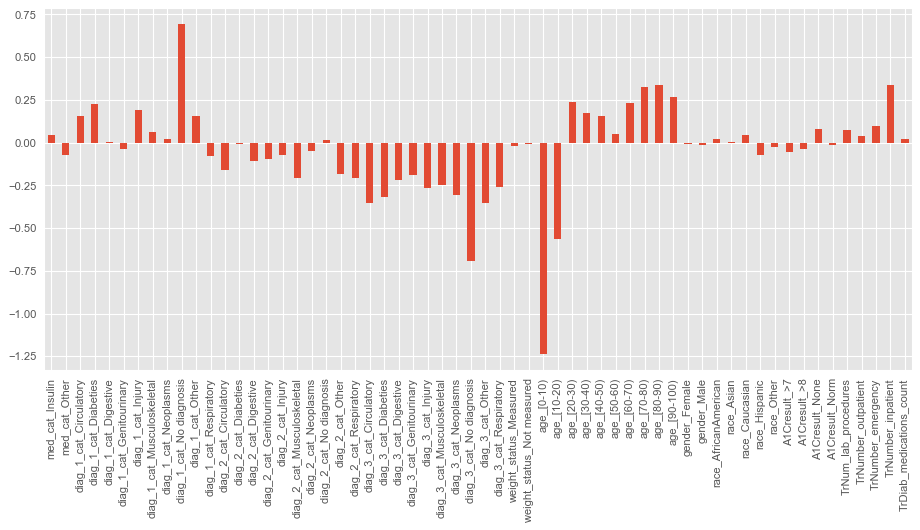

In [10]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
weights = lr_clf.coef_.T
weights = pd.Series(lr_clf.coef_[0],index=diab_wDummies.columns)
print (weights)
weights.plot(kind='bar')
plt.show()

We can see those following variables which have low weight and we belive doesn't have high importance for our model: TrDiab_medications_count, TrNumber_emergency, TrNumber_outpatient, TrNum_lab_procedures, gender. We will delete them from the subsequent model building because they present just irrelevant noise which can be reduced by increasing regularization parameter. But we prefer just to delete them.



In [11]:
#drop variables with low weight
new_diab=diab_wDummies.copy()
toDrop=["TrDiab_medications_count", "TrNumber_emergency", "TrNumber_outpatient", "TrNum_lab_procedures","gender_Female",
       "gender_Male"]
new_diab.drop(new_diab[toDrop],axis=1, inplace = True)

Split data set on test and train indeces.

In [12]:
from sklearn.model_selection import ShuffleSplit

X_new = new_diab.values #values of all other variables

num_cv_iterations = 100

cvob = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=666)
for train_indices, test_indices in cvob.split(X_new,y): 
    X_train = X_new[train_indices]
    y_train = y[train_indices]
    
    X_test = X_new[test_indices]
    y_test = y[test_indices]
print(cvob)

ShuffleSplit(n_splits=100, random_state=666, test_size=0.2, train_size=None)


Because this is medical data and this is important to us to catch more patients that going to be readmitted we'll try to tune our parameters to have high recall.

In [13]:
#tunning parameters
#high recall
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt


grid = {'C': np.arange(0.001,1.5,0.1), 'solver': ['liblinear']}
clf = LogisticRegression(penalty='l2', random_state=777, tol=10, class_weight='balanced',dual=True)
gs = GridSearchCV(clf, grid, scoring='recall', cv=5)
fitted=gs.fit(X_train, y_train)
y_pred = fitted.best_estimator_.predict(X_test)
print('Best C:',gs.best_estimator_.C) 
print('Best recall:',gs.best_score_) 
print (mt.confusion_matrix(y_test, y_pred))
print ("F1-score: ",mt.f1_score(y_test, y_pred))
print ("Precision: ",mt.precision_score(y_test, y_pred))
print ("Recall: ",mt.recall_score(y_test, y_pred))

Best C: 0.001
Best recall: 0.72200601469
[[9322 8740]
 [ 844 1448]]
F1-score:  0.232051282051
Precision:  0.142127993718
Recall:  0.631762652705


As we can see this way we have a lot of observations misclassified as being readmitted (almost half of all persons not readmitted were misclassified), which is not good for prediction.Now we'll try to tune our parameters to find a balance between precision and recall using F1-score.With this model, we have more balance and caught more than half of readmitted patients. However, we had to misclassify more not readmitted patients. If we want to classify more patients as not being readmitted we'll have to pay the price of more misclassifications among the not readmitted group.




In [14]:
#balance between precision and recall
grid = {'C': np.arange(0.001,1.5,0.1), 'solver': ['liblinear']}
clf = LogisticRegression(penalty='l2', random_state=777, tol=10, class_weight='balanced',dual=True)
gs = GridSearchCV(clf, grid, scoring='f1', cv=5)
#fit calculated parameters on train set
fitted=gs.fit(X_train, y_train)
#make predictions and calculate parameters on a test set
y_pred = fitted.best_estimator_.predict(X_test)
print('Best C:',gs.best_estimator_.C) 
print('Best F1-score:',gs.best_score_) 
print (mt.confusion_matrix(y_test, y_pred))
print ("F1-score: ",mt.f1_score(y_test, y_pred))
print ("Precision: ",mt.precision_score(y_test, y_pred))
print ("Recall: ",mt.recall_score(y_test, y_pred))

Best C: 0.501
Best F1-score: 0.248326001788
[[12021  6041]
 [ 1129  1163]]
F1-score:  0.244945240101
Precision:  0.16143808995
Recall:  0.507417102967


We will tune our model to have slightly more recall by making regularization parameter equal to 0.4. Which is slightly less than the best parameter for F1-score and more than the best parameter for high recall. We'll pay price of less precision for having higher recall.

In [15]:
clf = LogisticRegression(penalty='l2', random_state=777, tol=10, C=0.4, class_weight='balanced',dual=True)

cv_pr=[]
cv_rc=[]
cv_f1=[]
for iter_num, (train_indices, test_indices) in enumerate(cvob.split(X_new,y)):
    clf.fit(X_new[train_indices],y[train_indices])  # train object
    y_hat = clf.predict(X_new[test_indices]) # get test set precitions
    pr = mt.precision_score(y[test_indices],y_hat)
    rc=mt.recall_score(y[test_indices],y_hat)
    f1=mt.f1_score(y[test_indices],y_hat)
    cv_pr.append(pr)
    cv_rc.append(rc)
    cv_f1.append(rc)
    conf = mt.confusion_matrix(y[test_indices],y_hat)

print ('Average F1-score in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_f1)/len(cv_f1))
print ('Average Precision in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_pr)/len(cv_pr))
print ('Average Recall in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_rc)/len(cv_rc))
print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

Average F1-score in 100 CV iterations:
0.510988216811
Average Precision in 100 CV iterations:
0.163148779025
Average Recall in 100 CV iterations:
0.510988216811
confusion matrix
 [[12019  6043]
 [ 1129  1163]]


age_[0-10)                   -1.004796
diag_3_cat_No diagnosis      -0.711637
age_[10-20)                  -0.584794
diag_3_cat_Circulatory       -0.256713
diag_3_cat_Other             -0.235234
diag_3_cat_Diabeties         -0.227889
diag_1_cat_Respiratory       -0.226052
diag_3_cat_Musculoskeletal   -0.209836
diag_3_cat_Neoplasms         -0.199080
diag_3_cat_Respiratory       -0.175180
diag_2_cat_Respiratory       -0.164861
diag_2_cat_Musculoskeletal   -0.163225
diag_2_cat_Other             -0.162291
diag_2_cat_Circulatory       -0.139803
diag_3_cat_Digestive         -0.138326
diag_1_cat_Genitourinary     -0.137783
diag_1_cat_Digestive         -0.130927
diag_2_cat_Genitourinary     -0.128644
diag_1_cat_Musculoskeletal   -0.124413
diag_1_cat_Neoplasms         -0.114563
diag_3_cat_Injury            -0.094949
med_cat_Other                -0.076353
diag_2_cat_Diabeties         -0.058693
race_Hispanic                -0.054045
diag_3_cat_Genitourinary     -0.051613
diag_2_cat_Digestive     

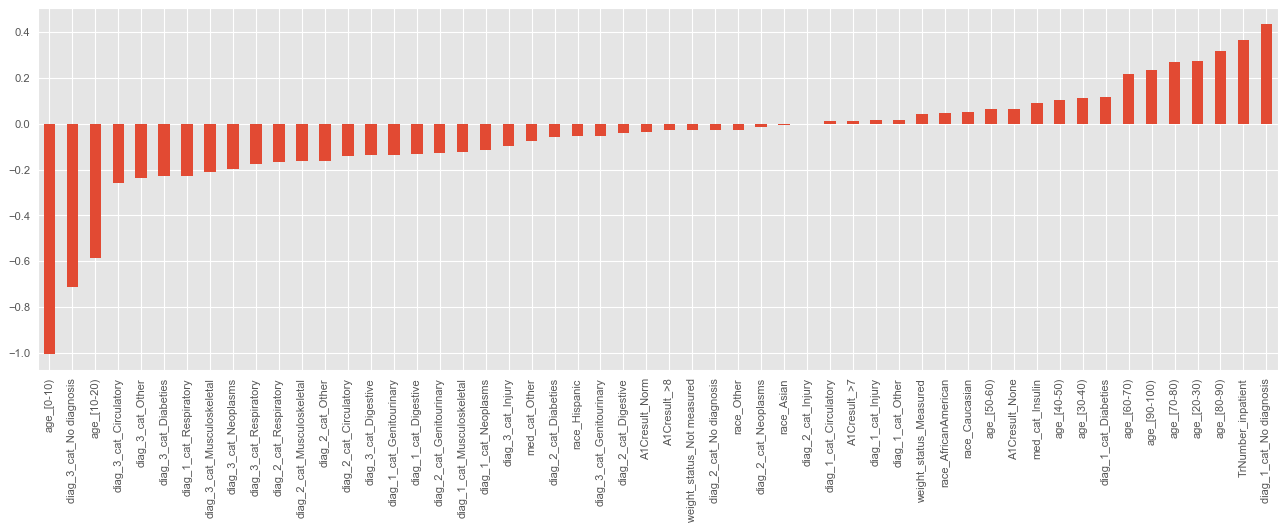

In [26]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(num=None, figsize=(10,15), dpi=80, facecolor='w', edgecolor='k')
weights = pd.Series(clf.coef_[0],index=new_diab.columns).sort_values(ascending=True)
weights.plot(kind='bar', figsize=(20,6))
print (weights)

On the plot above weights of variables sorted in ascending order. All variables with weights to the left from 0 responsible for the higher chance of person not to be readmitted and variables with bars to the right from 0 responsible for increasing of the chance for the person to be readmitted.
Some variables have more importance then other because they have stronger predictive power. They better separate the data set.

We can interpret the weights of variables for prediction the following way:
1. No diagnosis in primary diagnosis category.
   With this condition, people have greate chance to be readmitted into the hospital within 30 days. This is expected. Because if person sick and don't have diagnosis this person won't be able to receive proper treatment and therefore has a greater chance to be readmitted.
2. A number of inpatient visits.
   Have high weight because if the person often visits a doctor it means he/she has some sickness which needed to be treated.
3. Age more than 20 tend to be readmitted into the hospital more often than people in the age before 20.
4. People with certain group of primary diagnosis tend to be readmitted more often.
5. Insulin VS not insulin
   This is expected too. Usually, the person with diabetes uses insulin either because he/she has type 1 diabetes, gestational diabetes or complicated type 2 diabetes. Type 1 diabetes is hard to manage because the body doesn't produce insulin (which helps to get carbohydrates inside the cell), the person with gestational diabetes is going to be readmitted to a hospital soon for baby delivery and sometimes due to poor diabetes management. And for type 2 diabetes insulin is a last resort. It means that pills failed and only injections of insulin left. 
6. A1Cresult, if it wasn't measured, has a higher weight of all categories in an A1Cresult group. It means that if the A1Cresult wasn't measured person has the higher chance to be readmitted. This is no surprise. If the doctors in the hospital don't know about the importance of this measurement the person isn't going to get qualified care. If the person has A1C in normal range it means he/she has proper diabetes management and it is easier to cure condition when diabetes under control.
7. The race has some importance with Caucasian and African American race tended to be less readmitted into the hospital within 30 days. But this variable has low importance.
8. The weight_status variable which shows if the weight was measured or not shows expected result that if the weight was measured the person has fewer chances to be readmitted. This is can be due to several reasons. One of them - this person received better care, the other reason - the diagnosis which requires weight measurement for treatment is more easy to cure.
9. If there is not additional secondary diagnosis it increases chances of the person not being readmitted. It can be explained that person who has fewer diagnoses (ie. less than 3) have fewer chances to be readmitted.

It worth to notice, though, that weights are changing. They are highly dependant on the variables in a model. If the variable has the low weight it can fluctuate from the contributing to readmittance to contributing to not readmittance dependent on the other variables in the model.


## Implementing Support Vector Machine Algorithm

### Using Stochastic Gradient Descent

Due to significant size of our data and computational effort to get support vectors we'll use stochastic descent for calculations.

In [17]:
%%time
# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics as mt
cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)

regularize_const = 0.1
iterations = 1000
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', max_iter=iterations, n_jobs=-1, penalty='l2',random_state=666,class_weight='balanced')

for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(X[train_idx],y[train_idx])
    yhat = svm_sgd.predict(X[test_idx])
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    f1 = mt.f1_score(y[test_idx],yhat)
    pr = mt.precision_score(y[test_idx],yhat)
    rc = mt.recall_score(y[test_idx],yhat)

print('Precision:', pr)
print('Recall:', rc)
print('F1-score:', f1)
print("Confusion matrix: \n",conf)

Precision: 0.166637360061
Recall: 0.500616305688
F1-score: 0.250043975374
Confusion matrix: 
 [[30986 14218]
 [ 2836  2843]]
Wall time: 18.7 s


As we can see that F1-score for SVM model is comparable with F1-score produced by logistic regression. Possibly because data indeed linearly separated or because we didn't use kernels for SVM. The time to compute SVM with stochastic descent is significantly lower than time to compute logistic regression model, however, it depends on a number of iterations used for computation.

Now we will resample our data to get support vectors. Because our data contains more than one hundred thousands records we will use a subset of size about 20 000 records (20% of data set) for this purpose. Otherwise, it will require significant computational effort.

In [18]:
resam_diab=diab.sample(frac=0.2)
#create dummies
dummiesList=["med_cat","diag_1_cat","diag_2_cat","diag_3_cat","weight_status","age","gender","race","A1Cresult"]
resam_wDummies = pd.get_dummies(resam_diab[dummiesList])
listToCopy=["TrNum_lab_procedures", "TrNumber_outpatient","TrNumber_emergency", "TrNumber_inpatient", "TrDiab_medications_count",
           "readmitted_Group"]
resam_wDummies= pd.concat((resam_wDummies, resam_diab[listToCopy]), axis=1)

if 'readmitted_Group' in resam_wDummies:
    y_resam = resam_wDummies['readmitted_Group'].values #array with values hold in variable "readmitted_Group"
    del resam_wDummies['readmitted_Group'] #delete variable
    X_resam = resam_wDummies.values #values of all other variables

In [19]:
for train_indices, test_indices in cv_object.split(X_resam,y_resam): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
#for c=10 answer is the same. Computation of c=100 and c=1000 takes an eternity

svm_clf=SVC(C=0.01, kernel='linear',class_weight='balanced')
svm_clf.fit(X_train, y_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

rc = mt.recall_score(y_test,y_hat)
pr = mt.precision_score(y_test,y_hat)
f1 = mt.f1_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('F1-score:', f1 )
print ("Precision:", pr)
print ("Recall:", rc)
print(conf)

F1-score: 0.242659279778
Precision: 0.167944785276
Recall: 0.437125748503
[[2485 1085]
 [ 282  219]]


age_[0-10)                   -3.943737e-02
diag_1_cat_No diagnosis      -1.690173e-02
diag_2_cat_Genitourinary     -1.212077e-02
diag_2_cat_Circulatory       -1.210090e-02
diag_2_cat_Other             -1.205480e-02
diag_2_cat_Respiratory       -1.205406e-02
diag_2_cat_Musculoskeletal   -1.200773e-02
diag_2_cat_Digestive         -1.196584e-02
diag_2_cat_Diabeties         -1.194058e-02
diag_2_cat_Neoplasms         -1.190667e-02
diag_2_cat_No diagnosis      -1.160284e-02
diag_3_cat_No diagnosis      -1.098760e-02
diag_3_cat_Digestive         -1.069922e-02
diag_3_cat_Other             -1.061053e-02
diag_3_cat_Circulatory       -1.059417e-02
diag_3_cat_Musculoskeletal   -1.048447e-02
diag_3_cat_Respiratory       -1.047979e-02
diag_3_cat_Neoplasms         -1.046815e-02
diag_3_cat_Diabeties         -1.045762e-02
diag_3_cat_Genitourinary     -1.032253e-02
diag_3_cat_Injury            -7.103893e-03
A1Cresult_>8                 -1.685438e-04
A1Cresult_None               -9.071761e-05
TrNumber_ou

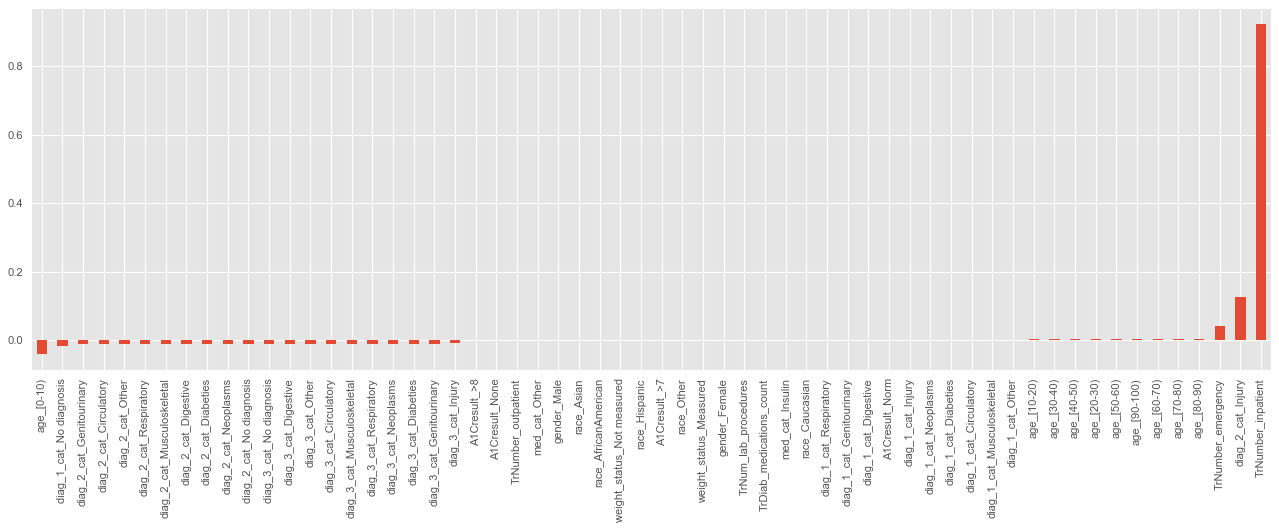

In [20]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(num=None, figsize=(10,15), dpi=80, facecolor='w', edgecolor='k')
weights = pd.Series(svm_clf.coef_[0],index=resam_wDummies.columns).sort_values(ascending=True)
weights.plot(kind='bar', figsize=(20,6))
print (weights)

In [21]:
df_tested_on = resam_wDummies.iloc[train_indices]
# now get the support vectors from the trained model
df_support = resam_wDummies.iloc[svm_clf.support_,:]

#add deleted variable readmited_Group to dataframes df_support and resam_wDummies
df_support.loc[:,'readmitted_Group'] = y_resam[svm_clf.support_] 
resam_wDummies.loc[:,'readmitted_Group'] = y_resam 
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13438 entries, 95278 to 63861
Data columns (total 61 columns):
med_cat_Insulin               13438 non-null uint8
med_cat_Other                 13438 non-null uint8
diag_1_cat_Circulatory        13438 non-null uint8
diag_1_cat_Diabeties          13438 non-null uint8
diag_1_cat_Digestive          13438 non-null uint8
diag_1_cat_Genitourinary      13438 non-null uint8
diag_1_cat_Injury             13438 non-null uint8
diag_1_cat_Musculoskeletal    13438 non-null uint8
diag_1_cat_Neoplasms          13438 non-null uint8
diag_1_cat_No diagnosis       13438 non-null uint8
diag_1_cat_Other              13438 non-null uint8
diag_1_cat_Respiratory        13438 non-null uint8
diag_2_cat_Circulatory        13438 non-null uint8
diag_2_cat_Diabeties          13438 non-null uint8
diag_2_cat_Digestive          13438 non-null uint8
diag_2_cat_Genitourinary      13438 non-null uint8
diag_2_cat_Injury             13438 non-null uint8
diag_2_cat_Musculosk

#### Now we'll plot density of variables choosen for support vectors versus original for variables with low weight.

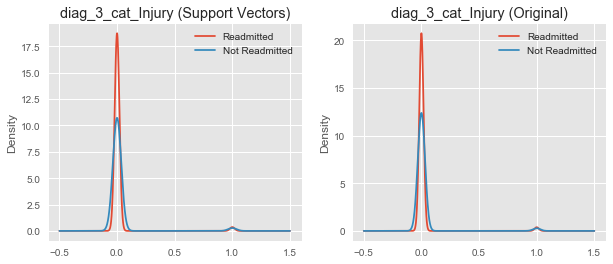

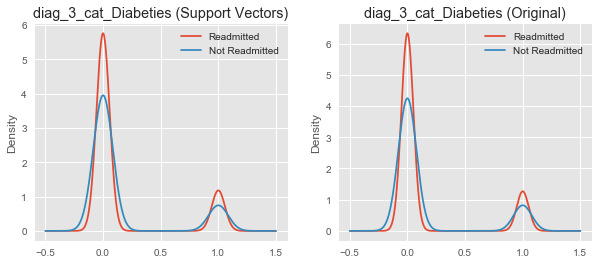

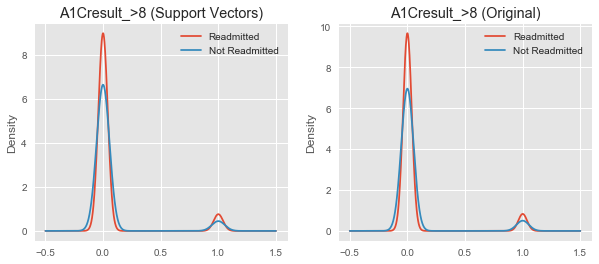

In [22]:
from pandas.tools.plotting import boxplot
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(dpi=80, facecolor='w', edgecolor='k')
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['readmitted_Group'])
df_grouped = resam_wDummies.groupby(['readmitted_Group'])

# plot KDE of Different variables
vars_to_plot = ['diag_3_cat_Injury','diag_3_cat_Diabeties', 'A1Cresult_>8']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector distribution
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Readmitted','Not Readmitted'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Readmitted','Not Readmitted'])
    plt.title(v+' (Original)')

As we can see the data isn't really different between support vectors and original for different groups. We weren't able to produce density plot for variables with high weights due to during computations we encountered with singular matrix.

Now we will plot a PCA to see the if the groups are linearely separable.
We put markes for group readmitted several times bigger or they will drown in a see of readmitted.
For this work the code was taken and adjusted from the http://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-classifier-in-an-svm-supervised-learning-model/ website.

In [23]:
#reduce dimensionality of data set to 2 feauters.
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_train)
pca_2d = pca.transform(X_train)


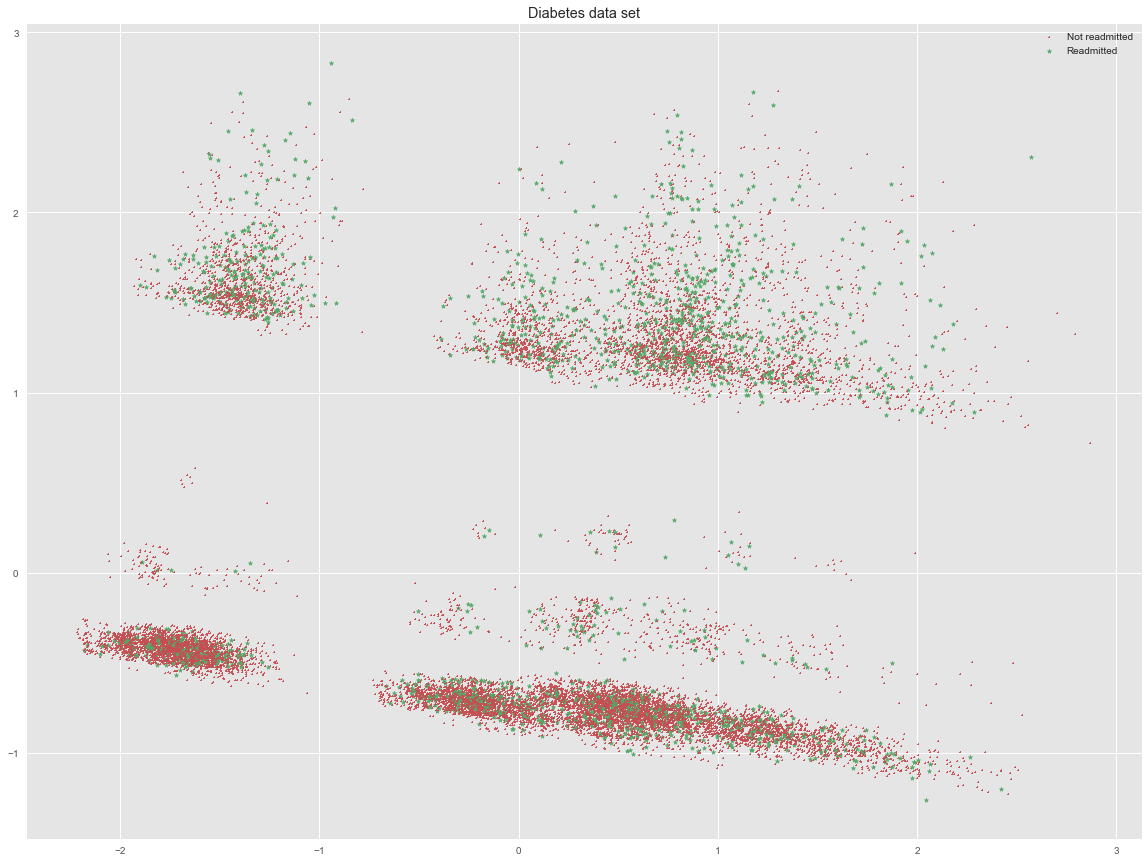

In [27]:
#part of the code was taken from:
#http://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-classifier-in-an-svm-supervised-learning-model/
import pylab as pl
plt.figure(figsize=(20,15))
for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', s=1,marker='+')
    elif y_train[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', s=20,marker='*')
pl.legend([c1, c2], ['Not readmitted', 'Readmitted'])
pl.title('Diabetes data set')
pl.show()

We can see that our data isn't really linearaly separable, so it's hard to make a separating hyperplane and there is a need in some kind of a kernel.

### Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.



* The key concept behind Logistic and SVM Model is that Support Vector Machines use the widest possible separating margin/hyperplane, while Logistic Regression optimizes the log likelihood function, with probabilities modeled by the sigmoid function.
 
* In Logistic Regression, every training point has a certain influence on the estimated logistic regression function in other words "obvious" points can sometimes be very influential.

* SVM's  works in such a way that only points near the decision boundary really make a difference. These points are use to classify a new data point. 

* Prediction time for SVM is really less. This stems from the fact that new test instances (records) will be assigned based only on the support vectors (the sign it will has according to desicion boundary). These is the reason why SVM'S are referred to SPARSE LEARNERS. 

* SVM also provides a lot of flexibility in modeling, Although they are inherently meant for maximizing linear decision boundaries, We could also  extend its application to solve non-linear problems by using the "kernel trick" 

* Logistic Regression performs well and also flexible for large feature dimensions. However the use of SVM, often lead to smaller training and generalization errors because it uses relatively small number of support vectors and it's very applicable to data sets with large numbers of samples. 

* The disadvantage of SVM is the time needed to train data. It takes significantly more time than time to train logistic regression model.


# Extra Work

### Using an ensemble learning method for classification 

The basic principle of appplying a random forest algorithm is that a group of “weak learners” can come together to become  a “strong learner”. The use of Random Forests are a powertool and means for making predictions considering that they do not overfit because of the law of large numbers. Introducing the right kind of randomness makes them accurate for regression and classification problems. Lets implement random forest on our data set





In [65]:
# Divide our features into X and Y for modelling 
X= diab_wDummies.iloc[::,1:60]
#target variable
diab_rf.loc[:,'readmitted_Group'] = y
y = diab_rf["readmitted_Group"]
  

In [66]:
#import modeling packages

from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Split the data into 40% test and 60% training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)





### Use Random forest for feature importance

In [67]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
clf.fit(X_train, y_train)

# Create a list of feature names
feat_labels = X_train.columns.tolist()

# Print the name and gini importance of each feature in our dataset
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)


('med_cat_Other', 0.017630765280435529)
('diag_1_cat_Circulatory', 0.018735999913462434)
('diag_1_cat_Diabeties', 0.0096522424248557913)
('diag_1_cat_Digestive', 0.010972351451052605)
('diag_1_cat_Genitourinary', 0.0088762674590976351)
('diag_1_cat_Injury', 0.0097748705664671646)
('diag_1_cat_Musculoskeletal', 0.0074322555773340014)
('diag_1_cat_Neoplasms', 0.015321197030311658)
('diag_1_cat_No diagnosis', 0.00033916790375424551)
('diag_1_cat_Other', 0.010632856332730862)
('diag_1_cat_Respiratory', 0.012274347014626612)
('diag_2_cat_Circulatory', 0.02195609733581106)
('diag_2_cat_Diabeties', 0.014016426022353151)
('diag_2_cat_Digestive', 0.0077257135187246999)
('diag_2_cat_Genitourinary', 0.013004819122428499)
('diag_2_cat_Injury', 0.0058572984057996191)
('diag_2_cat_Musculoskeletal', 0.0043762996558169348)
('diag_2_cat_Neoplasms', 0.017211825458300412)
('diag_2_cat_No diagnosis', 0.00083891331517974347)
('diag_2_cat_Other', 0.013181409931058123)
('diag_2_cat_Respiratory', 0.0140001303

In [68]:
# Create a selector object that will use the random forest classifier to identify
# select features that have an importance of more than 0.01
sfm = SelectFromModel(clf, threshold=0.01)


# Train the selector
sfm.fit(X_train, y_train)

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

med_cat_Other
diag_1_cat_Circulatory
diag_1_cat_Digestive
diag_1_cat_Neoplasms
diag_1_cat_Other
diag_1_cat_Respiratory
diag_2_cat_Circulatory
diag_2_cat_Diabeties
diag_2_cat_Genitourinary
diag_2_cat_Neoplasms
diag_2_cat_Other
diag_2_cat_Respiratory
diag_3_cat_Circulatory
diag_3_cat_Diabeties
diag_3_cat_Genitourinary
diag_3_cat_Neoplasms
diag_3_cat_Other
diag_3_cat_Respiratory
age_[40-50)
age_[50-60)
age_[60-70)
age_[70-80)
age_[80-90)
gender_Female
gender_Male
race_AfricanAmerican
race_Caucasian
A1Cresult_None
TrNum_lab_procedures
TrNumber_outpatient
TrNumber_emergency
TrNumber_inpatient
TrDiab_medications_count


In [69]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [70]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=5000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Prediction on test data

In [71]:
# Lets apply our Featured Classifier To The Test Dataset
y_important_pred = clf_important.predict(X_important_test)



In [72]:
# View The Accuracy Of Our  Model
accuracy_score(y_test, y_important_pred)

0.88201046503058445

In [73]:
#Create a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_important_pred)

array([[35819,   354],
       [ 4449,    85]], dtype=int64)

In [74]:
#create a classification report
from sklearn.metrics import classification_report
from sklearn import metrics
print(metrics.classification_report(y_test, y_important_pred))

             precision    recall  f1-score   support

          0       0.89      0.99      0.94     36173
          1       0.19      0.02      0.03      4534

avg / total       0.81      0.88      0.84     40707

